In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import  preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.cross_validation import KFold,StratifiedKFold
import matplotlib.pyplot as plt
from mochi import *

/opt/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
from bs4 import BeautifulSoup
import string

In [2]:
#lodaing data
data_path = "../../kaggleData/2sigma/"
train_file = data_path + "train.json"
test_file = data_path + "test.json"
train_df = pd.read_json(train_file)
test_df = pd.read_json(test_file)
print(train_df.shape)
print(test_df.shape)


(49352, 15)
(74659, 14)


In [3]:
#try xgboost
#fucntion from SRK
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, \
     seed_val=0, early_stop = 20,num_rounds=10000, eta = 0.1,\
     max_depth = 6,cv_dict = None,verbose_eval=True):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = eta
    param['max_depth'] = max_depth
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y,feature_names=feature_names)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y,feature_names=feature_names)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist,\
        early_stopping_rounds=early_stop,evals_result = cv_dict,verbose_eval = verbose_eval)
    else:
        xgtest = xgb.DMatrix(test_X,feature_names=feature_names)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [22]:
def stripTagsAndUris(x):
    uri_re = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>???“”‘’]))'
    if x:
        # BeautifulSoup on content
        soup = BeautifulSoup(x, "html.parser")
        # Stripping all <code> tags with their content if any
        if soup.code:
            soup.code.decompose()
        # Get all the text out of the html
        text =  soup.get_text()
        # Returning text stripping out all uris
        return re.sub(uri_re, "", text)
    else:
        return ""
    
    #define punctutaion filter
def removePunctuationAndNumber(x):
    x = re.sub(r'[^\x00-\x7f]',r' ',x)
    removing = string.punctuation
    removed = re.sub("["+removing+"]", " ", x)
    removed = re.sub(r"\d",'',removed)
    return removed

def getUpperTokens(tokenList):
    number = 0
    for word in tokenList:
        if re.match('[A-Z]{2,}',word)!=None:
            number+=1
    if len(tokenList) > 0:
        return number*1.0/len(tokenList)
    else:
        return -1

In [4]:
def temporalHouseTypePerf(train_df,test_df,update_df =None):
    temp=pd.concat([train_df,pd.get_dummies(train_df.interest_level)], axis = 1)
    tempTrain = temp[['house_type','dayofyear','high','low','medium']].set_index('house_type')
    tempTest = test_df[['house_type','dayofyear']]
    tempJoin = tempTest.join(tempTrain,on='house_type',how='left', rsuffix='_toSum')
    
    #3 day performance
    performance_3 = tempJoin[tempJoin['dayofyear'] - tempJoin['dayofyear_toSum']<4]
    performance_3 = performance_3.groupby(performance_3.index).sum()[['high','low','medium']]
    performance_3['total'] = performance_3['high']+performance_3['low']+performance_3['medium']
    performance_3['ht3perf'] = (2*performance_3['high']+performance_3['medium'])*1.0/performance_3['total']

    
    performance_7 = tempJoin[tempJoin['dayofyear'] - tempJoin['dayofyear_toSum']<8]
    performance_7 = performance_7.groupby(performance_7.index).sum()[['high','low','medium']]
    performance_7['total'] = performance_7['high']+performance_7['low']+performance_7['medium']
    performance_7['ht7perf'] = (2*performance_7['high']+performance_7['medium'])*1.0/performance_7['total']
    
    performance_14 = tempJoin[tempJoin['dayofyear'] - tempJoin['dayofyear_toSum']<15]
    performance_14 = performance_14.groupby(performance_14.index).sum()[['high','low','medium']]
    performance_14['total'] = performance_14['high']+performance_14['low']+performance_14['medium']
    performance_14['ht14perf'] = (2*performance_14['high']+performance_14['medium'])*1.0/performance_14['total']

    
    performance_30 = tempJoin[tempJoin['dayofyear'] - tempJoin['dayofyear_toSum']<31]
    performance_30 = performance_30.groupby(performance_30.index).sum()[['high','low','medium']]
    performance_30['total'] = performance_30['high']+performance_30['low']+performance_30['medium']
    performance_30['ht30perf'] = (2*performance_30['high']+performance_30['medium'])*1.0/performance_30['total']

    update = pd.concat([performance_3[['ht3perf']],performance_7[['ht7perf']],\
                        performance_14[['ht14perf']],performance_30[['ht30perf']]],axis=1).fillna(-1)

    if update_df is None: update_df = test_df
    
    new_features = ['ht3perf','ht7perf','ht14perf','ht30perf']
    
    for f in new_features:
        if f not in update_df.columns: 
             update_df[f] = np.nan
    
    update_df.update(update)

In [5]:
#basic numerical features
features_to_use  = ["bathrooms", "bedrooms", "latitude", "longitude", "price"]

In [6]:
#some transfromed features
# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))

# convert the created column to datetime object so as to extract more features 
train_df["created"] = pd.to_datetime(train_df["created"])

# Let us extract some features like year, month, day, hour from date columns #
train_df["created_year"] = train_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour

#some new numerical features related to the price
train_df["price_per_bath"] =  (train_df["price"]*1.0/train_df["bathrooms"]).replace(np.Inf,-1)
train_df["price_per_bed"] = (train_df["price"]*1.0/train_df["bedrooms"]).replace(np.Inf,-1)
train_df["bath_per_bed"] = (train_df["bathrooms"]*1.0/train_df["bedrooms"]).replace(np.Inf,-1)
train_df["price_per_room"] = (train_df["price"]*1.0/(train_df["bedrooms"]+train_df["bathrooms"])).replace(np.Inf,-1)

# adding all these new features to use list # "listing_id",
features_to_use.extend(["num_photos", "num_features", "num_description_words",\
                        "created_year","listing_id", "created_month", "created_day", "created_hour"])
#price new features
features_to_use.extend(["price_per_bed","bath_per_bed","price_per_room"])


In [25]:
train_df['upperTokenRate']=train_df['description']\
       .apply(stripTagsAndUris)\
       .apply(removePunctuationAndNumber)\
       .apply(lambda x : x.split() if x is not None else [])\
       .apply(getUpperTokens)

/opt/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:219: UserWarning: "." looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


In [7]:
#for latter use
train_df["dayofyear"] = train_df["created"].dt.dayofyear
#test_df["dayofyear"] = test_df["created"].dt.dayofyear

In [8]:
#for latter use
train_df['house_type']=map(lambda x,y:(x,y),train_df['bedrooms'],train_df['bathrooms'])
train_df['house_type']=train_df['house_type'].apply(str)

In [27]:
features = list(features_to_use)
categorical = ["display_address", "street_address",'building_id','manager_id','house_type']
features.extend(categorical)
features.extend(['manager_id_perf','manager_id_nrank'])
features.extend(['cluster_id_10','cluster_id_30'])

features.extend(['house_type_perf','house_type_size'])
#features.extend(['cluster_id_30_perf'])#,'cluster_id_30'])
#features.append('upperTokenRate')

In [10]:
#prepare for training
target_num_map = {'high':0, 'medium':1, 'low':2}

train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))

KF=KFold(len(train_df),5,shuffle=True,random_state = 42)

In [54]:
#running and getting the cv from xgboost
cv_scores = []
cv_result = []

#K-FOLD already defined.If not ,use
#KF=KFold(len(train_X),5,shuffle=True,random_state = 42)
i=0
for dev_index, val_index in KF:
        result_dict = {}
                
        #split the orginal train set into dev_set and val_set
        dev_set, val_set = train_df.iloc[dev_index,:] , train_df.iloc[val_index,:] 
        
        getCluster(dev_set,val_set,30)
        getCluster(dev_set,val_set,10)
        
        """some preprocessing like feature constructed in cv manners"""
        skf=KFold(len(dev_set['interest_level']),5,shuffle=True,random_state = 42)
        #dev set adding manager skill
        for train,test in skf:
            performance_eval(dev_set.iloc[train,:],dev_set.iloc[test,:],feature='manager_id',k=5,g=1,
                           update_df = dev_set,smoothing=False)
            performance_eval(dev_set.iloc[train,:],dev_set.iloc[test,:],feature='house_type',k=5,g=1,
                           update_df = dev_set,smoothing=False)
            #temporalHouseTypePerf(dev_set.iloc[train,:],dev_set.iloc[test,:],update_df = dev_set)
            
        performance_eval(dev_set,val_set,feature='manager_id',k=5,g=1,smoothing=False)
        performance_eval(dev_set,val_set,feature='house_type',k=5,g=1,smoothing=False)

        #temporalHouseTypePerf(dev_set,val_set)

        categorical_size(dev_set,val_set,'house_type')

        
        for f in categorical:
            if dev_set[f].dtype=='object':
                #print(f)
                lbl = preprocessing.LabelEncoder()
                lbl.fit(list(dev_set[f])+list(val_set[f]))
                dev_set[f] = lbl.transform(list(dev_set[f].values))
                val_set[f] = lbl.transform(list(val_set[f].values))
        
        dev_X, val_X = dev_set[features].as_matrix(), val_set[features].as_matrix()
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        
        """ 
         runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, \
         seed_val=0, early_stop = 20,num_rounds=10000, eta = 0.1,\
         max_depth = 6,cv_dict = None):
         """
        
        preds, model = runXGB(dev_X, dev_y, val_X, val_y,early_stop  = 20,\
                              feature_names = features,cv_dict = result_dict,verbose_eval=100)
        loss = log_loss(val_y, preds)
        cv_scores.append(loss)
        cv_result.append(result_dict)
        i+=1
        print 'loss for the turn '+str(i)+' is '+str(loss)

/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0]	train-mlogloss:1.0323	test-mlogloss:1.03351
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[100]	train-mlogloss:0.4707	test-mlogloss:0.551377
[200]	train-mlogloss:0.400403	test-mlogloss:0.542457
Stopping. Best iteration:
[222]	train-mlogloss:0.388508	test-mlogloss:0.541954

loss for the turn 1 is 0.5438707966
[0]	train-mlogloss:1.03283	test-mlogloss:1.03423
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[100]	train-mlogloss:0.469883	test-mlogloss:0.549173
[200]	train-mlogloss:0.399794	test-mlogloss:0.541183
Stopping. Best iteration:
[201]	train-mlogloss:0.399337	test-mlogloss:0.54112

loss for the turn 2 is 0.541572847557
[0]	train-mlogloss:1.03195	test-mlogloss:1.03312
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until te

In [12]:
#plot the validation curv
cvResult = CVstatistics(cv_result,'mlogloss')
cvResult.turns

test0    251
test1    268
test2    279
test3    194
test4    246
Name: 278, dtype: int32

In [55]:
#cvResult.validCurve(stop=False)
#some errors at certain turn to see the descending
cv_scores
np.mean(cv_scores)

0.54251683483278379

In [15]:
#show the importance of the features
xgbImportance(model,'gain')

[('manager_id_perf', 0.13829892482077635),
 ('price', 0.053304361342733746),
 ('price_per_room', 0.050377704449702986),
 ('house_type_size', 0.048583313984863694),
 ('building_id', 0.04268580069423074),
 ('house_type', 0.041612735409251096),
 ('cluster_id_10', 0.040954277731166465),
 ('price_per_bed', 0.04021341671754079),
 ('num_photos', 0.035928247156541256),
 ('bedrooms', 0.030435925232107794),
 ('num_features', 0.029816806730578273),
 ('cluster_id_30', 0.029245396807511558),
 ('created_hour', 0.029152874190672765),
 ('longitude', 0.02784068038529328),
 ('latitude', 0.02721104208045398),
 ('ht30perf', 0.026548345833297286),
 ('ht7perf', 0.026061418435669316),
 ('house_type_perf', 0.02532412381066304),
 ('ht14perf', 0.02407227032014022),
 ('ht3perf', 0.02371787205444692),
 ('manager_id_nrank', 0.02311757777221477),
 ('bathrooms', 0.022638193674499166),
 ('listing_id', 0.02193902420762428),
 ('num_description_words', 0.02185911801613789),
 ('street_address', 0.021534677491419758),
 ('

In [12]:
temp=pd.concat([dev_set[['house_type','house_type_perf']],pd.get_dummies(dev_set.interest_level)], axis = 1)\
     .groupby('house_type').mean()
temp['count'] = dev_set.groupby('house_type').count().iloc[:,1]


In [13]:
temp2 = temp.sort_values(by = 'house_type_perf')[temp['count']>5]

/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


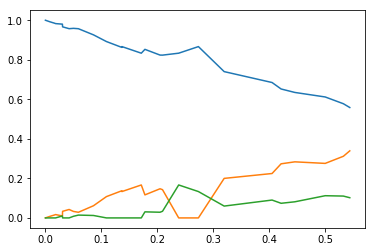

In [14]:
plt.plot(temp2['house_type_perf'],temp2['low'],\
        temp2['house_type_perf'],temp2['medium'],\
        temp2['house_type_perf'],temp2['high'])
plt.show()